# <font color='firebrick'><center>Report for Picard Stats</center></font>
### This report details the picardstats output tables that have been generated as part of running picard tool.
<br>







0





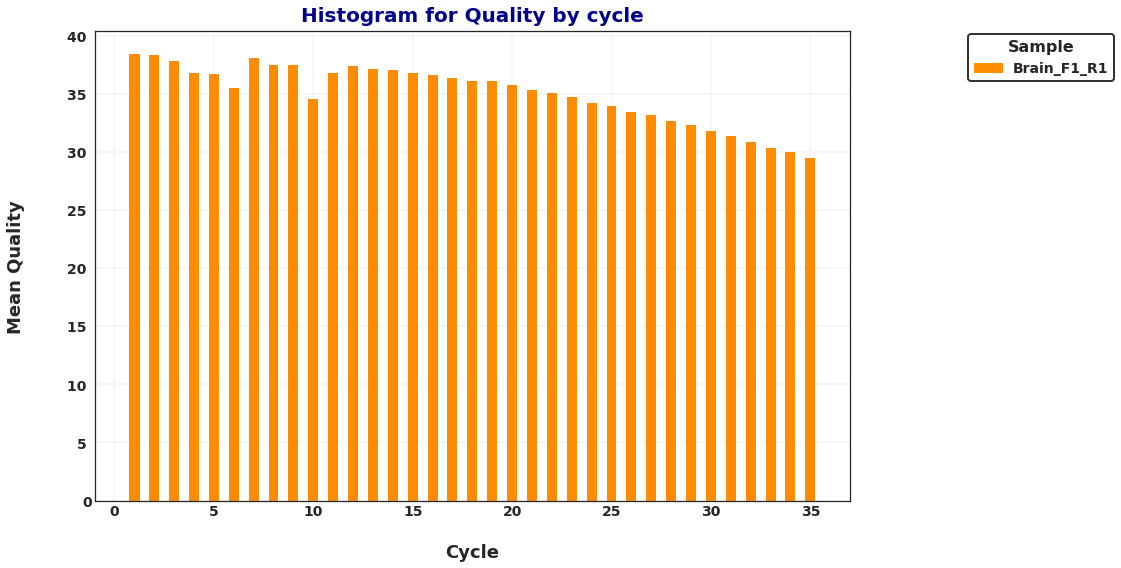

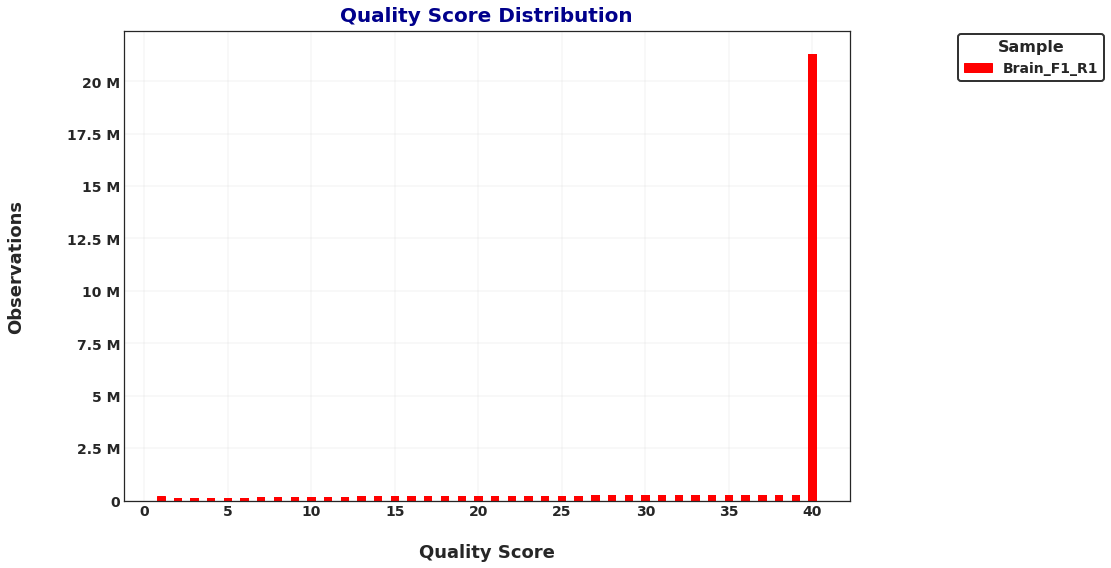





0





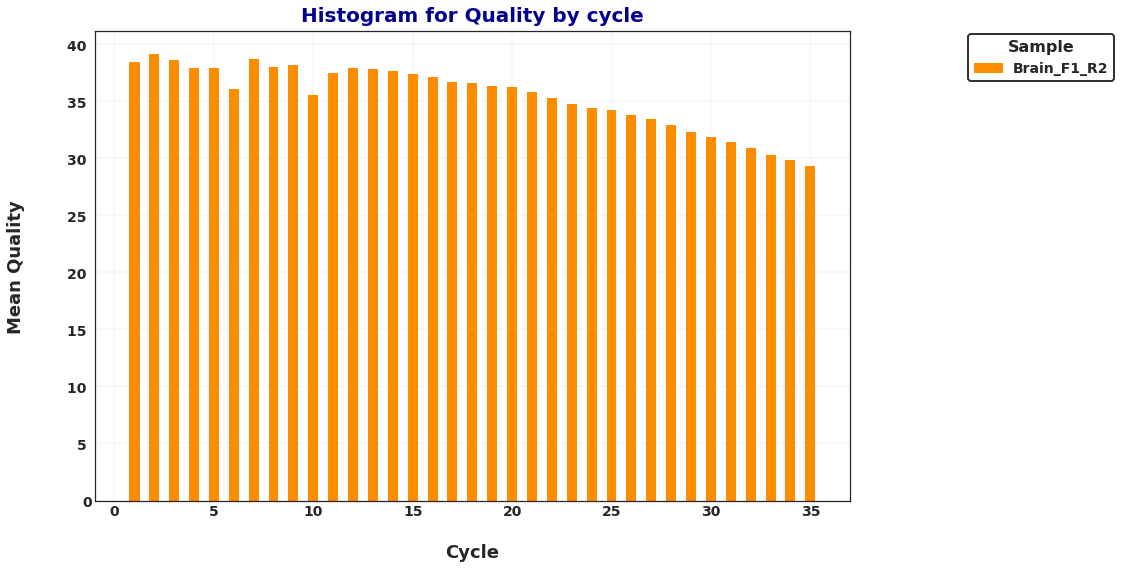

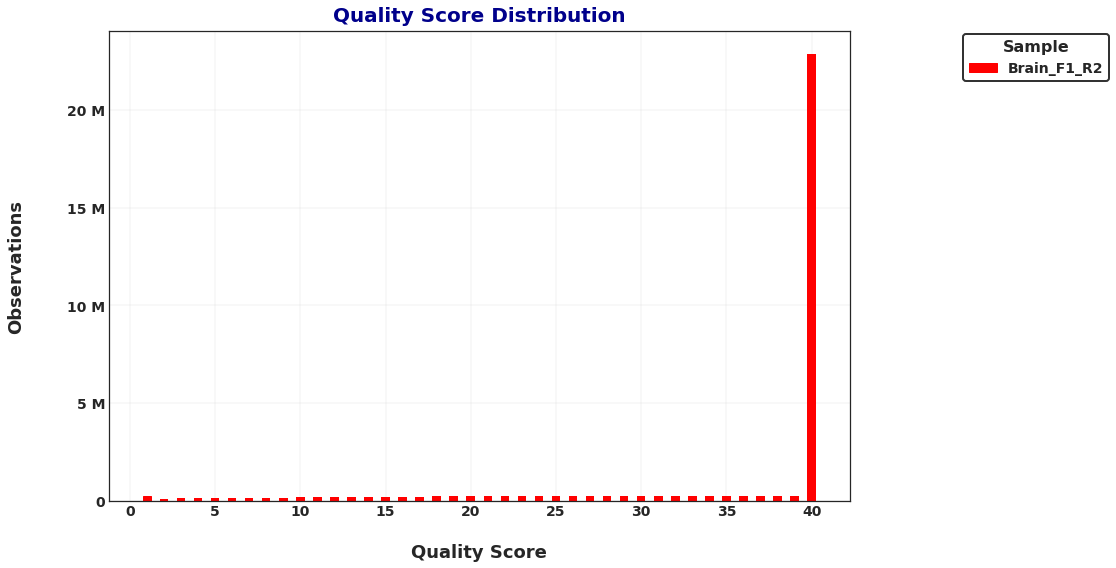





0





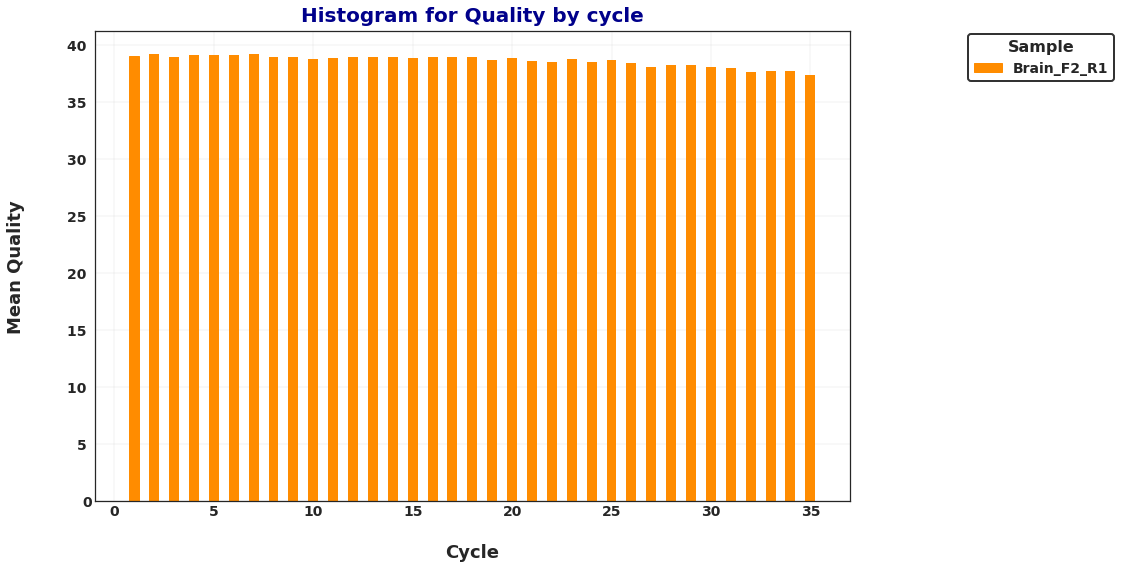

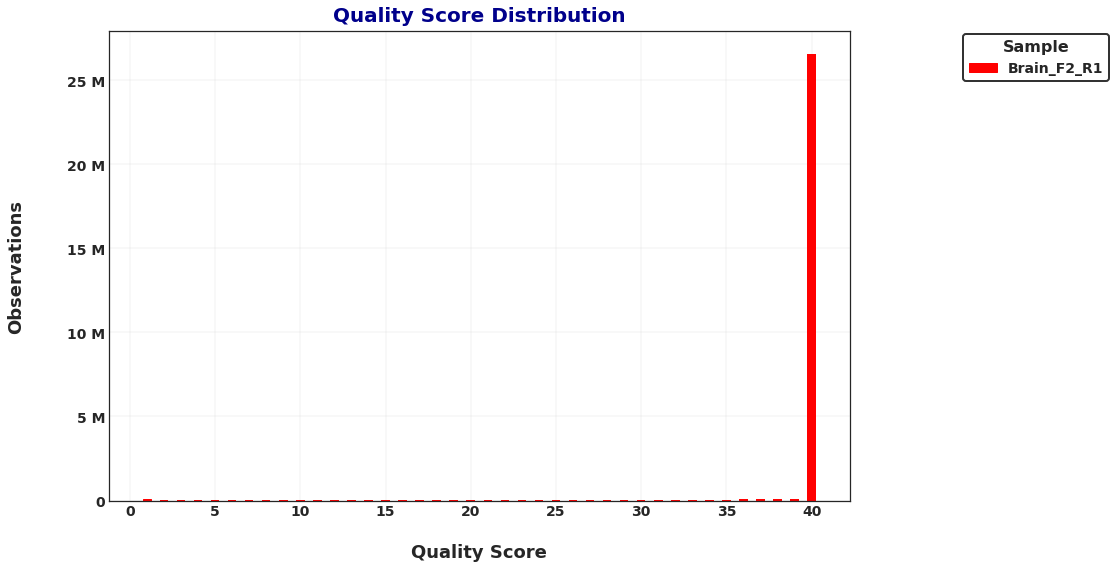





0





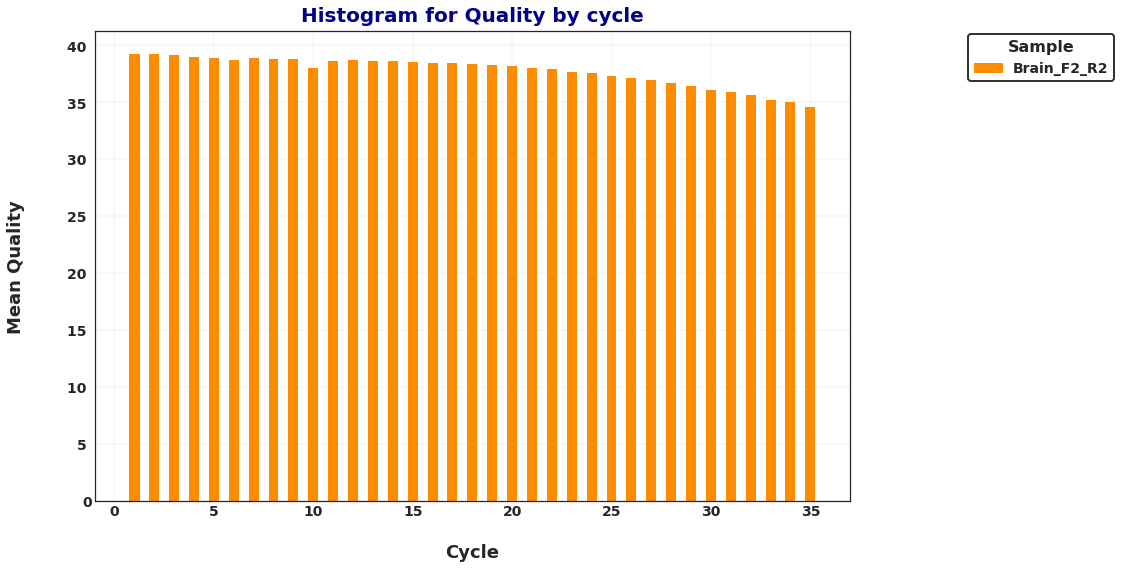

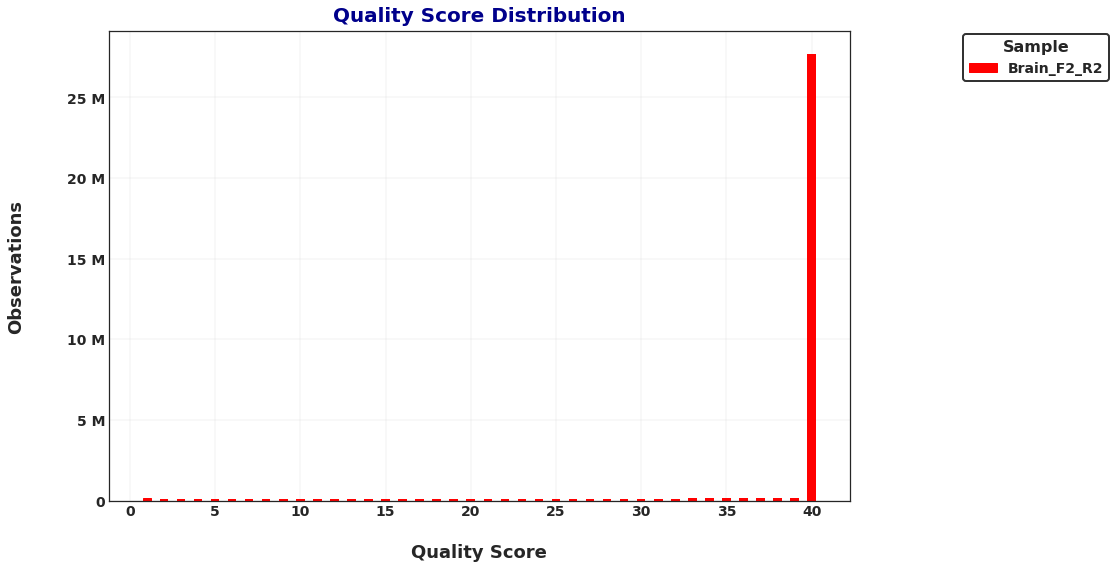





0





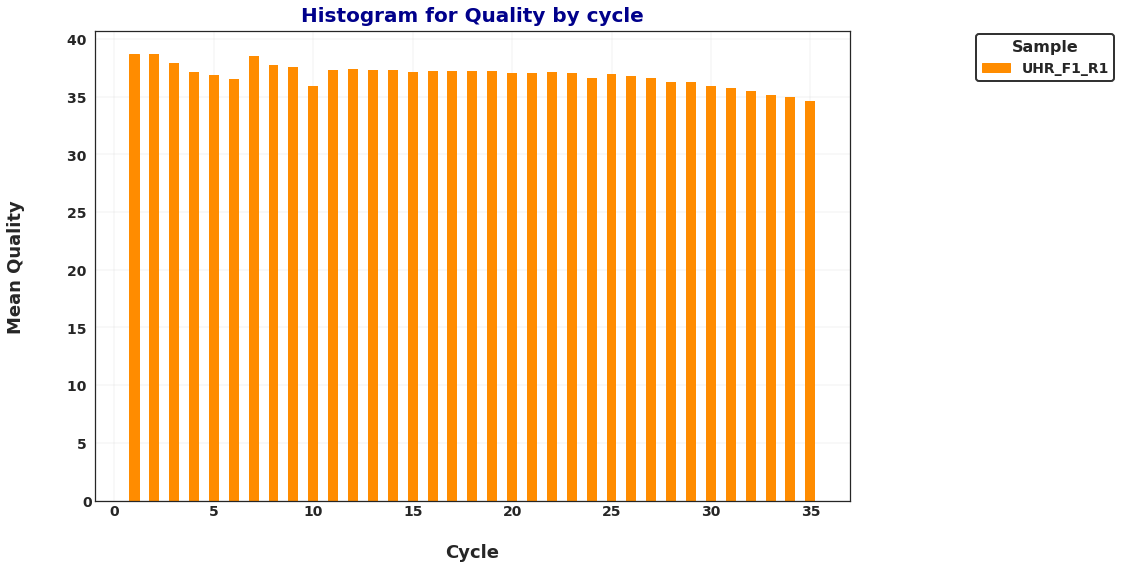

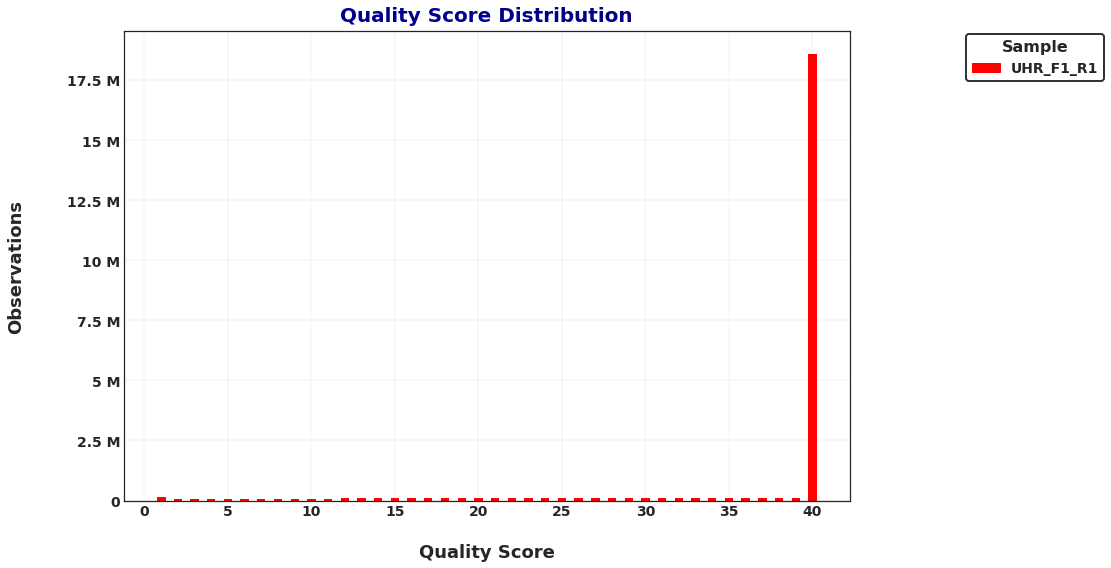





0





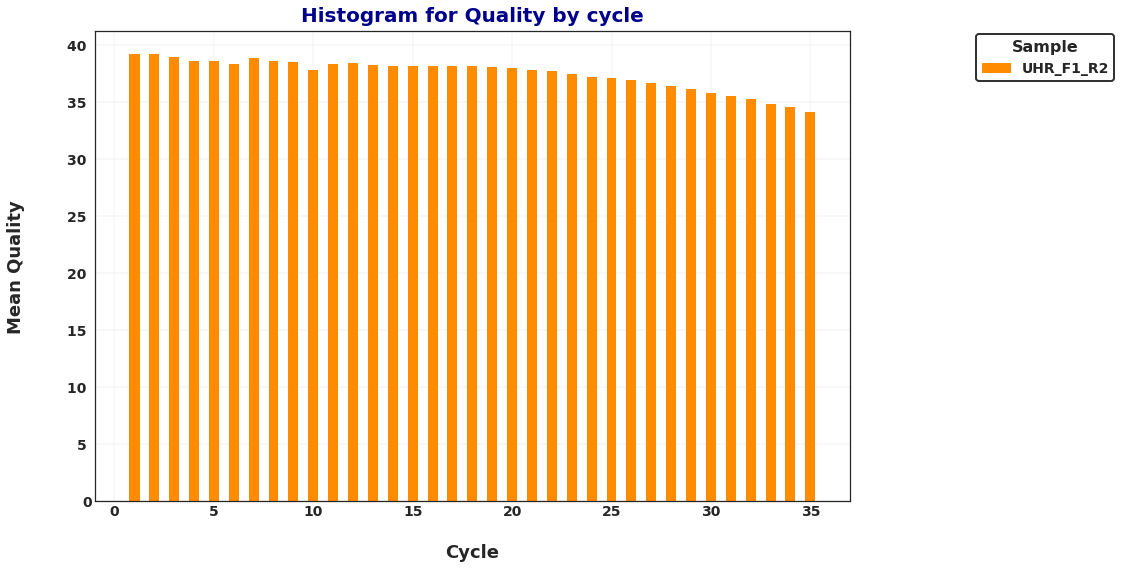

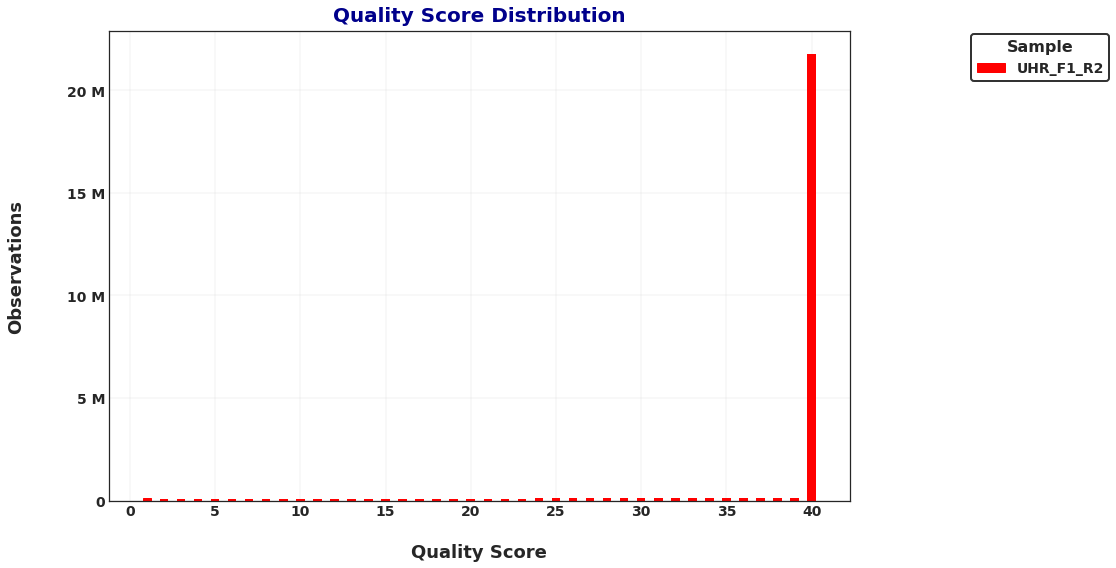

In [1]:
from IPython.display import display, Markdown
from IPython.display import HTML
import IPython.core.display as di
import csv
import numpy as np
import zlib
import CGAT.IOTools as IOTools
import itertools as ITL
import os
import string
import pandas as pd
import sqlite3
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages  # noqa: E402
#mpl.use('Agg')  # noqa: E402
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as font_manager
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib import rc, font_manager
import CGAT.Experiment as E
import math
from random import shuffle
import matplotlib as mpl
import datetime
import seaborn as sns
import nbformat
%matplotlib inline  


##################################################
#Plot customization
#plt.ioff()
plt.style.use('seaborn-white')
#plt.style.use('ggplot')
title_font = {'size':'20','color':'darkblue', 'weight':'bold', 'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'size':'18', 'weight':'bold'}
#For summary page pdf
'''To add description page
plt.figure() 
plt.axis('off')
plt.text(0.5,0.5,"my title",ha='center',va='center')
pdf.savefig()
'''
#Panda data frame cutomization
pd.options.display.width = 80
pd.set_option('display.max_colwidth', -1)

feature = ['MIN_INSERT_SIZE','MAX_INSERT_SIZE','MEAN_INSERT_SIZE','MEDIAN_INSERT_SIZE','MEDIAN_ABSOLUTE_DEVIATION',
           'PAIR_ORIENTATION','READ_GROUP','READ_PAIRS']
colors_category = ['yellowgreen', 'pink', 'gold', 'lightskyblue', 
              'orchid','darkgoldenrod','skyblue','b', 'red', 
              'darkorange','grey','violet','magenta','cyan',
              'hotpink','mediumslateblue']
threshold = 5

def check_table_exist(dbname):
      dbh = sqlite3.connect(dbname) 
      c = dbh.cursor()
      statement = "SELECT name FROM sqlite_master WHERE type='table' AND name='picard_stats_insert_size_metrics'";
      c.execute(statement)
      if not c.execute(statement).fetchone():  # if the table doesn't exist # OR if cursor.execute(table_check).fetchone() == "":
            value=0
      else:
            value=1
      return value

def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])

def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    #print(val, signf)
                    if str(val).split(".")[1] == "0":
                       return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

def getTables(dbname):
    '''
    Retrieves the names of all tables in the database.
    Groups tables into dictionaries by annotation
    '''
    dbh = sqlite3.connect(dbname)
    c = dbh.cursor()
    statement = "SELECT name FROM sqlite_master WHERE type='table'"
    c.execute(statement)
    tables = c.fetchall()
    print(tables)
    c.close()
    dbh.close()
    return 

def readDBTable(dbname, tablename):
    '''
    Reads the specified table from the specified database.
    Returns a list of tuples representing each row
    '''
    dbh = sqlite3.connect(dbname)
    c = dbh.cursor()
    statement = "SELECT * FROM %s" % tablename
    c.execute(statement)
    allresults = c.fetchall()
    c.close()
    dbh.close()
    return allresults

def getDBColumnNames(dbname, tablename):
    dbh = sqlite3.connect(dbname)
    res = pd.read_sql('SELECT * FROM %s' % tablename, dbh)
    dbh.close()
    return res.columns

def plotBar(df,i_index,name,track_name,colors,xname,titlename,yname):   
        fig,ax = plt.subplots()
        ax.grid(which='major', linestyle='-', linewidth='0.25')
        ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
        #index=list(range(1,len(df.loc[track_name])+1))
        index = df.loc[track_name]
        plt.bar(index,df.loc[df.index[i_index]],0.50,color=colors,label=df.index[i_index],edgecolor=colors)
        fig = plt.gcf()
        fig.set_size_inches(12,8)
        plt.xticks(fontsize = 14,weight='bold')
        plt.yticks(fontsize = 14,weight='bold')
        legend_properties = {'weight':'bold','size':'14'}
        leg = plt.legend(title="Sample",prop=legend_properties,bbox_to_anchor=(1.36,1.01),frameon=True)
        leg.get_frame().set_edgecolor('k')
        leg.get_frame().set_linewidth(2)
        leg.get_title().set_fontsize(16)
        leg.get_title().set_fontweight('bold')
        plt.xlabel(xname,**axis_font)
        plt.ylabel(yname,**axis_font,labelpad=42)
        plt.title(titlename, **title_font)
        plt.tight_layout()
        #plt.savefig(''.join([df.index[i_index],name,'.png']),bbox_inches='tight',pad_inches=0.6)
        print("\n\n")
        plt.show()
        plt.close()
        return fig
    
def displayTable(newdf,name):
    # Display table
    styles = [
    hover(),
    dict(selector="th", props=[("font-size", "120%"),
                               ("text-align", "center"),
                              ]),                               
    dict(selector="td", props=[("font-size", "120%"),
                               ("text-align", "center"),
                              ]),
    dict(selector="caption", props=[("caption-side", "top"),
                                   ("text-align", "center"),
                                   ("font-size", "100%")])
    ]
    df1 = (newdf.style.set_table_styles(styles).set_caption(name))
    display(df1)
    print("\n")
    
def displayInsertsize(dbname,tablename,index):
    trans = pd.DataFrame(readDBTable(dbname,tablename))
    trans.columns = getDBColumnNames(dbname,tablename)
    df = trans
    newdf=df[feature]
    newdf.columns = ['MIN INSERT SIZE','MAX INSERT SIZE','MEAN INSERT SIZE','MEDIAN INSERT SIZE',
                     'MEDIAN ABSOLUTE DEVIATION',
                     'PAIR ORIENTATION','READ GROUP','READ PAIRS']
    newdf.index = [df['track']]
    del newdf.index.name
    displayTable(newdf.iloc[index].to_frame().T,"Insert Size Metrices")
    
def picardQualityByCycle(dbname, tablename,index,pdf):
    trans = pd.DataFrame(readDBTable(dbname,tablename))
    trans.columns = getDBColumnNames(dbname,tablename)
    df = trans.T
    fig = plotBar(df,index,"_picardstatsQuality_by_cycle",'cycle','darkorange',
                 '\nCycle',"Histogram for Quality by cycle","Mean Quality")
    #pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
    return pdf

def picardQualityScore(dbname, tablename,index,pdf):
    trans = pd.DataFrame(readDBTable(dbname,tablename))
    trans.columns = getDBColumnNames(dbname,tablename)
    df = trans.T
    fig = plotBar(df,index,"_picardstatsQualityScore",'quality','red',
                 '\nQuality Score',"Quality Score Distribution","Observations")
    #pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
    return pdf

def PicardStatsReport(dbname, tablename):
    ind_flag = check_table_exist(dbname)
    if(ind_flag==0):
        tablename = "picard_stats_quality_by_cycle_histogram"
    trans = pd.DataFrame(readDBTable(dbname,tablename))
    trans.columns = getDBColumnNames(dbname,tablename)
    df = trans.T
    for i in range(0,(df.shape[0]-1)):
        #pdf=PdfPages(str("_".join([df.index[i],"picard_stats_summary.pdf"])))
        print("\n\n\n")
        
        print(ind_flag)
        if(ind_flag == 1):
            displayInsertsize(dbname, "picard_stats_insert_size_metrics",i)
            fig = plotBar(df,i,"_picardstatsInsert_size",'insert_size','green',
                           '\nInsert size',"Insert size histogram for all reads","Frequency")
            #pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
        picardQualityByCycle(dbname,"picard_stats_quality_by_cycle_histogram",i,pdf)
        picardQualityScore(dbname,"picard_stats_quality_distribution_histogram",i,pdf)
        #pdf.close()
    
#getTables("csvdb")#a80975
PicardStatsReport("../csvdb","picard_stats_insert_size_histogram")







